In [58]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
from PIL import Image
from imutils import face_utils
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [3]:
train_ds_dir = "../dataset/train_set/"    
test_ds_dir = "../dataset/val_set/"     
lm_model_file_path = "../lm_model/shape_predictor_68_face_landmarks.dat"

In [21]:
# label_map = {
#     0: "Neutral",
#     1: "Happy",
#     2: "Sad",
#     3: "Surprise",
#     4: "Fear",
#     5: "Disgust",
#     6: "Anger",
#     7: "Contempt"
# }
label_map = {
    0: "anger", 
    1: "contempt", 
    2: "disgust", 
    3: "fear", 
    4: "happiness", 
    5: "neutral", 
    6: "sadness", 
    7: "surprise"
}
label_update = {
    0: 5,
    1: 4,
    2: 6,
    3: 7,
    4: 3,
    5: 2,
    6: 0,
    7: 1
}
face_bound_pts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18]

In [5]:
face_detector = dlib.get_frontal_face_detector()
lm_predictor = dlib.shape_predictor(lm_model_file_path)

In [6]:
train_img_path = os.path.join(train_ds_dir, "images")
train_label_path = os.path.join(train_ds_dir, "annotations")
test_img_path = os.path.join(test_ds_dir, "images")
test_label_path = os.path.join(test_ds_dir, "annotations")

train_imgs = os.listdir(train_img_path)
train_labels = os.listdir(train_label_path)
test_imgs = os.listdir(test_img_path)
test_labels = os.listdir(test_label_path)

In [7]:
print(len(train_imgs), len(train_labels) / 4)
print(len(test_imgs), len(test_labels) / 4)

287651 287651.0
3999 3999.0


In [8]:
def get_image_orientation(image_path):
    # Extract EXIF orientation from the image
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        orientation = exif_data.get(274, 1)  # Default to 1 if orientation tag not present
        return orientation
    except (AttributeError, IndexError, KeyError):
        # Handle cases where EXIF data is not available
        return 1

def apply_orientation(image, orientation):
    # Apply auto-orientation based on the EXIF orientation tag
    if orientation == 1:
        return image
    elif orientation == 3:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif orientation == 6:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif orientation == 8:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return image

In [9]:
X_train = []
y_train = []

for f in train_imgs:
    f_id = int(f.strip().split('.')[0])
    label_file_path = os.path.join(train_label_path, f"{f_id}_exp.npy")
    label = int(str(np.load(label_file_path)))

    ifp = os.path.join(train_img_path, f)
    img = cv2.imread(ifp)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Auto-orientation with EXIF-orientation stripping
    orientation = get_image_orientation(ifp)
    img_gray = apply_orientation(img_gray, orientation)
    img_gray = cv2.resize(img_gray, (48, 48), interpolation=cv2.INTER_LINEAR)

    detect_rects = face_detector(img_gray, 1)

    for rect in detect_rects:
        lms = lm_predictor(img_gray, rect)
        lms = face_utils.shape_to_np(lms).astype(np.int32)
        mask = np.zeros((48, 48), dtype=np.uint8)
        
        bound_lms_arr = []
        for pt in face_bound_pts:
            bound_lms_arr.append(lms[pt - 1])
        bound_lms_arr = np.array([bound_lms_arr], dtype=np.int32) 

        cv2.fillPoly(mask, bound_lms_arr, 255)
        data = cv2.bitwise_and(img_gray, img_gray, mask=mask)

        X_train.append(data)
        y_train.append(label_update[label])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [15]:
print(X_train.shape, y_train.shape)

(194696, 48, 48) (194696,)


In [16]:
X_val = []
y_val = []

for f in test_imgs:
    f_id = int(f.strip().split('.')[0])
    label_file_path = os.path.join(test_label_path, f"{f_id}_exp.npy")
    label = int(str(np.load(label_file_path)))

    ifp = os.path.join(test_img_path, f)
    img = cv2.imread(ifp)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Auto-orientation with EXIF-orientation stripping
    orientation = get_image_orientation(ifp)
    img_gray = apply_orientation(img_gray, orientation)
    img_gray = cv2.resize(img_gray, (48, 48), interpolation=cv2.INTER_LINEAR)

    detect_rects = face_detector(img_gray, 1)

    for rect in detect_rects:
        lms = lm_predictor(img_gray, rect)
        lms = face_utils.shape_to_np(lms).astype(np.int32)
        mask = np.zeros((48, 48), dtype=np.uint8)
        
        bound_lms_arr = []
        for pt in face_bound_pts:
            bound_lms_arr.append(lms[pt - 1])
        bound_lms_arr = np.array([bound_lms_arr], dtype=np.int32) 

        cv2.fillPoly(mask, bound_lms_arr, 255)
        data = cv2.bitwise_and(img_gray, img_gray, mask=mask)

        X_val.append(data)
        y_val.append(label_update[label])

X_val = np.array(X_val)
y_val = np.array(y_val)

In [17]:
print(X_val.shape, y_val.shape)

(3606, 48, 48) (3606,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(194696, 48, 48) (194696,)
(64899, 48, 48) (64899,)
(3606, 48, 48) (3606,)


Class: disgust


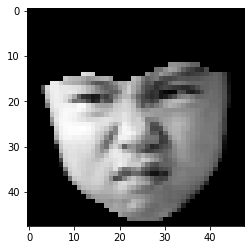

In [31]:
index = np.random.randint(X_train.shape[0])
img = X_train[index]
label = y_train[index]
print(f"Class: {label_map[label]}")
plt.imshow(img, cmap="gray")

Class: anger


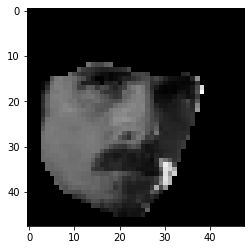

In [32]:
index = np.random.randint(X_test.shape[0])
img = X_test[index]
label = y_test[index]
print(f"Class: {label_map[label]}")
plt.imshow(img, cmap="gray")

Class: surprise


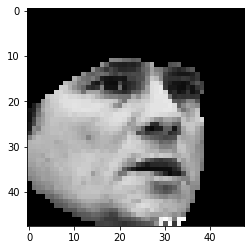

In [36]:
index = np.random.randint(X_val.shape[0])
img = X_val[index]
label = y_val[index]
print(f"Class: {label_map[label]}")
plt.imshow(img, cmap="gray")

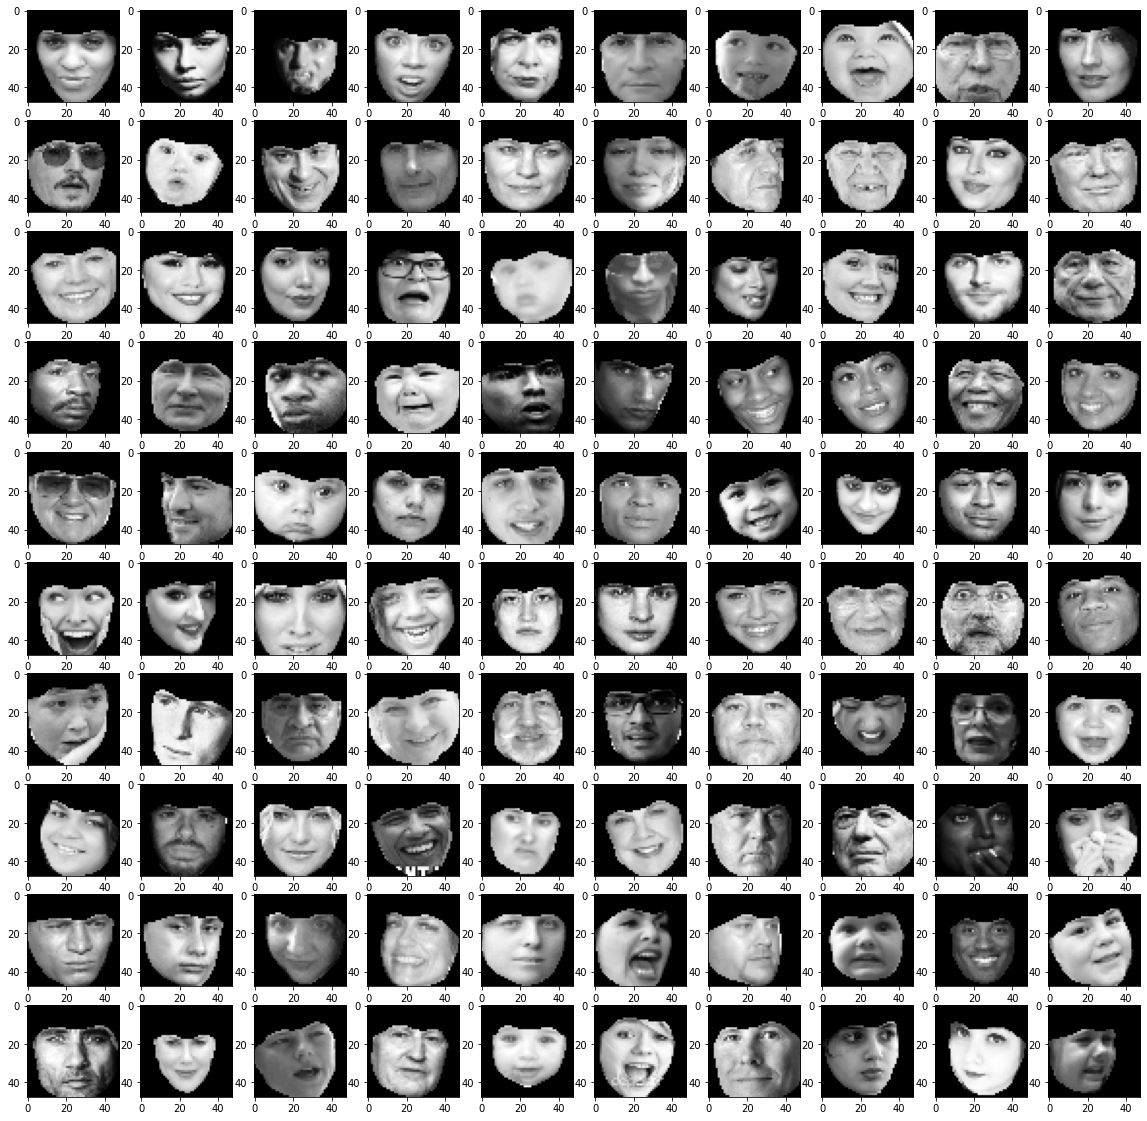

In [37]:
rows, cols = 10, 10

plt.figure(figsize=(20, 20))

for loc in range(rows * cols):
  index = np.random.randint(X_train.shape[0])
  img = X_train[index]
  
  plt.subplot(cols, rows, loc + 1)
  plt.imshow(img, cmap="gray")

plt.show()

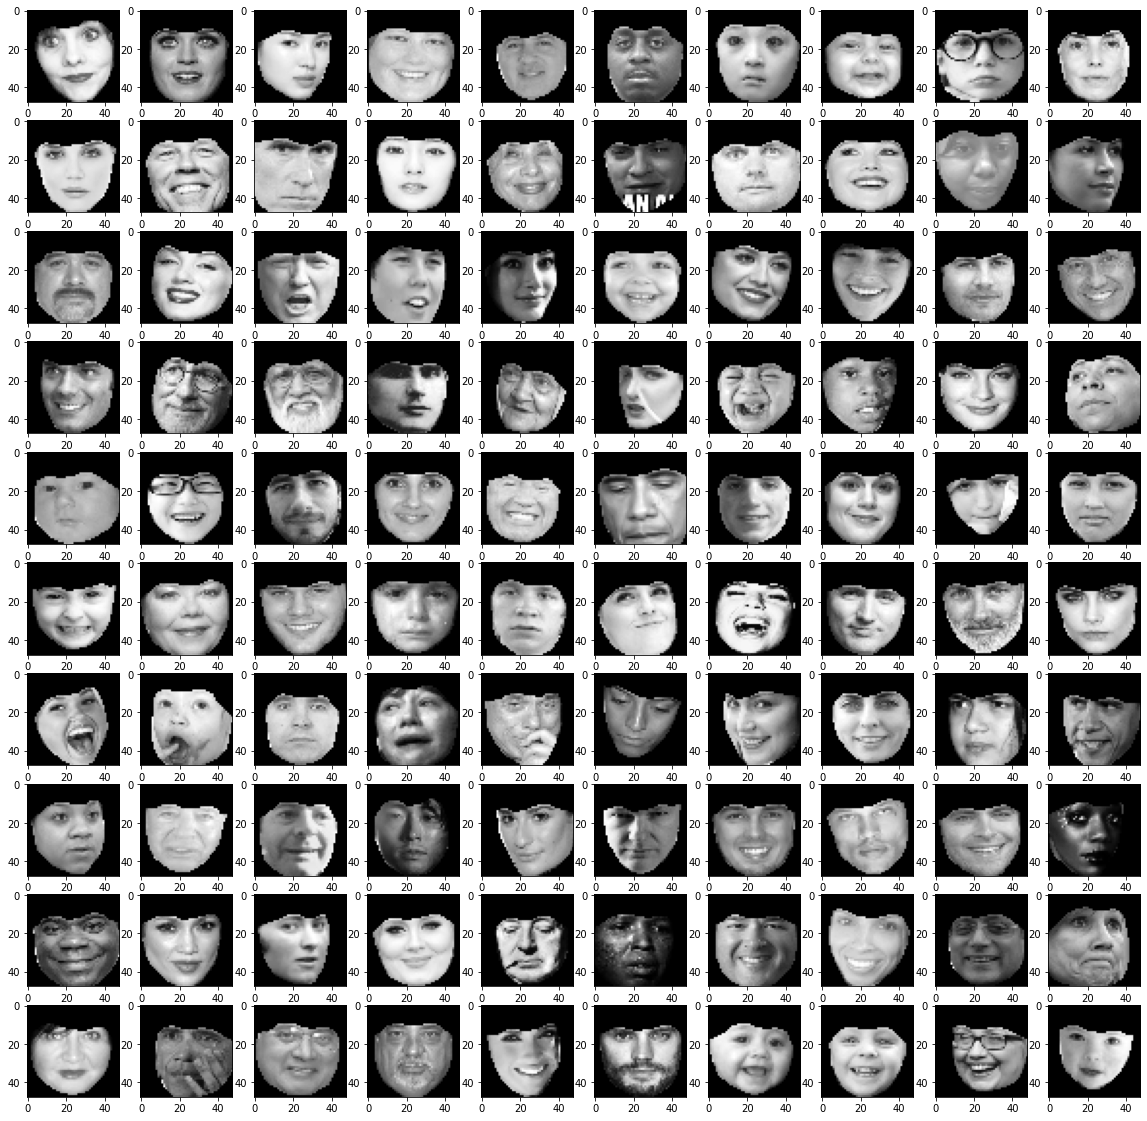

In [38]:
rows, cols = 10, 10

plt.figure(figsize=(20, 20))

for loc in range(rows * cols):
  index = np.random.randint(X_test.shape[0])
  img = X_test[index]
  
  plt.subplot(cols, rows, loc + 1)
  plt.imshow(img, cmap="gray")

plt.show()

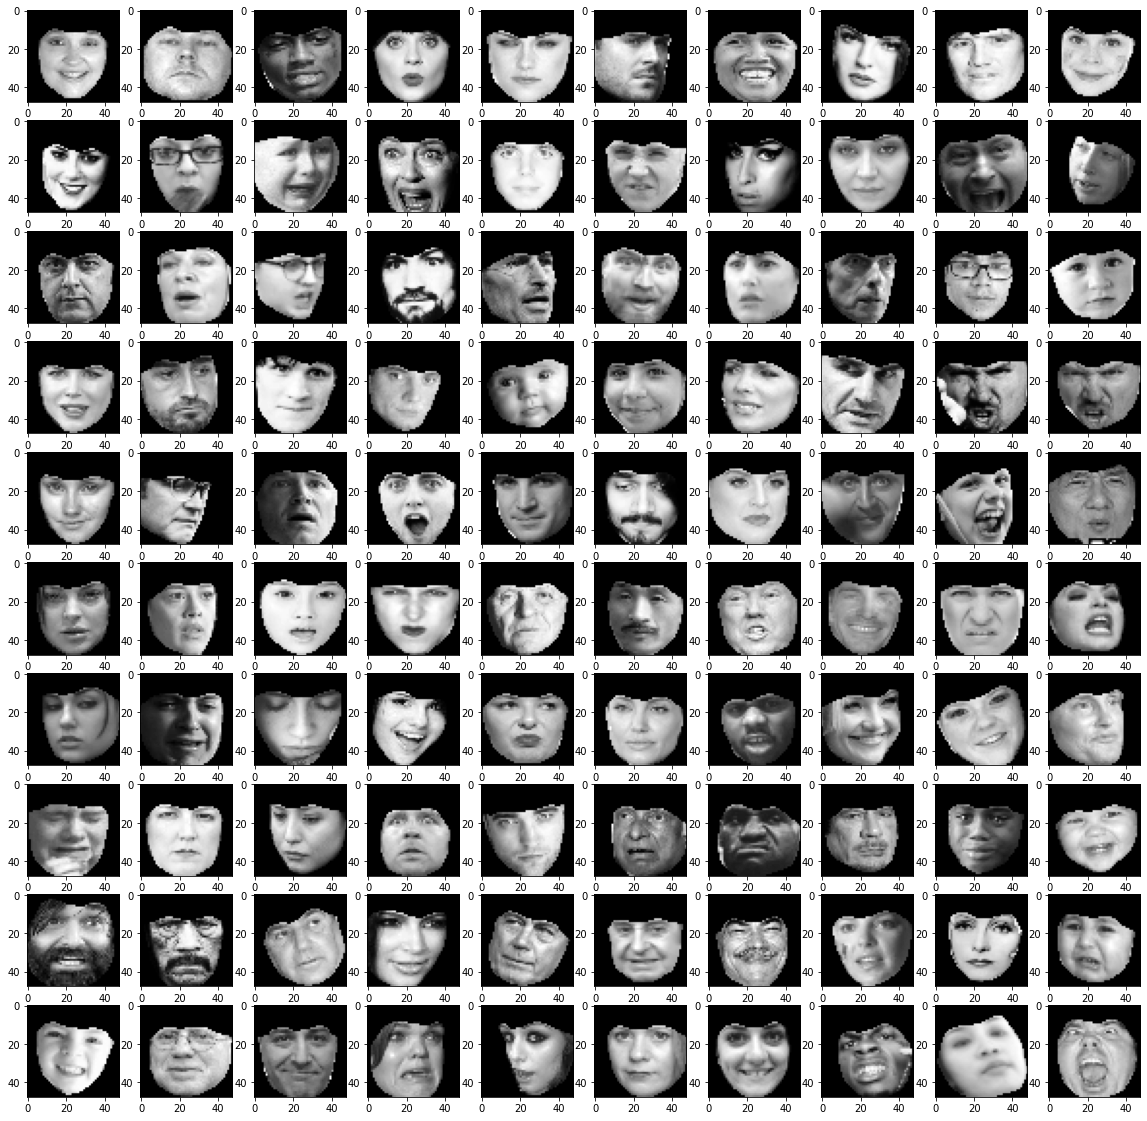

In [39]:
rows, cols = 10, 10

plt.figure(figsize=(20, 20))

for loc in range(rows * cols):
  index = np.random.randint(X_val.shape[0])
  img = X_val[index]
  
  plt.subplot(cols, rows, loc + 1)
  plt.imshow(img, cmap="gray")

plt.show()

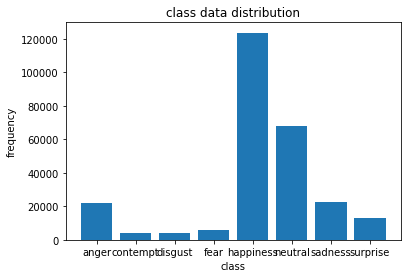

In [40]:
class_dist = []

for i in range(len(label_map)):
    class_dist.append(np.sum(y_train == i) + np.sum(y_test == i) + np.sum(y_val == i))

pos = range(len(class_dist))

plt.bar(pos, class_dist)
plt.xticks(pos, list(label_map.values()))
plt.title("class data distribution")
plt.xlabel("class")
plt.ylabel("frequency")

plt.show()

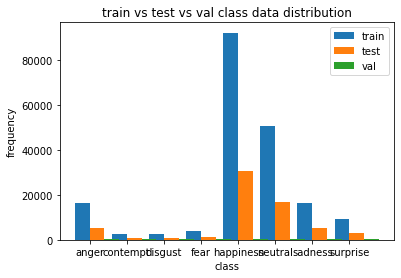

In [42]:
train_class_dist = []
test_class_dist = []
val_class_dist = []

for i in range(len(label_map)):
    train_class_dist.append(np.sum(y_train == i))
    test_class_dist.append(np.sum(y_test == i))
    val_class_dist.append(np.sum(y_val == i))

pos = np.array(list(range(len(class_dist))))

plt.bar(pos - 0.2, train_class_dist, 0.4, label="train")
plt.bar(pos + 0.2, test_class_dist, 0.4, label="test")
plt.bar(pos + 0.6, val_class_dist, 0.4, label="val")
plt.xticks(pos, list(label_map.values()))
plt.title("train vs test vs val class data distribution")
plt.xlabel("class")
plt.ylabel("frequency")
plt.legend()

plt.show()

In [55]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [56]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

In [59]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [60]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(194696, 48, 48, 1) (194696, 8)
(64899, 48, 48, 1) (64899, 8)
(3606, 48, 48, 1) (3606, 8)


In [61]:
np.save("../numpy/X_train", X_train)
np.save("../numpy/X_test", X_test)
np.save("../numpy/X_val", X_val)
np.save("../numpy/y_train", y_train)
np.save("../numpy/y_test", y_test)
np.save("../numpy/y_val", y_val)